In [ ]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.config import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata
%matplotlib inline

#Defining Equations

We consider parametric PDEs of the form:
$${\cal N}(u,s)=0$$
where, $u$ is the input function, and $s$ is the unknown PDE's solution (also a function).

Our PDE solution operator would be:
$$G(u):= s$$

**Burgers' Equation**

$$\frac{\partial s}{\partial t}+s\frac{\partial s}{\partial x}=\kappa\frac{\partial^2 s}{\partial x^2}, \quad (x,t)\in [{\rm -\rho\pi,\rho\pi}]\times[0,{\rm T}], \quad \kappa>0$$

$$s(x-\pi,t) = s(x+\pi,t), \quad s(x,0)=u(x)$$

where, $\kappa$ denotes the fluid viscosity, $\ u(x)$ is $2\pi$-periodic with zero mean i.e. $\int_{-\pi}^{\pi}u (t)dt=0$ and $\rho,{\rm T}\in{\mathbb R}$.

Hence ${{\cal G}}$ for above map the initial condition $u(x)$ to the solution to Burgers' equation $s(x,t)$.

Hence, we will approximate the implicit solution operator $({\cal G})$ with a DeepONet ($\tilde{{\cal G}}$) - which is a map as follows,

\begin{align*}
\mathbb{R}^m \times \mathbb{R}^2 &\rightarrow \mathbb{R}\\
(\vec{v},\vec{y}) &\mapsto \tilde{\cal G}(\vec{v},\vec{y}) := \sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(\vec{v})\cdot{\cal N}_{\mathrm{T,k}}(\vec{y})
\end{align*}

where ${\cal N}_{\mathrm{B}}$ and ${\cal N}_{\mathrm{T}}$ are any two neural nets mapping $\mathbb{R}^m \rightarrow \mathbb{R}^q$ amd $\mathbb{R}^2\rightarrow \mathbb{R}^q$ respectively.

And $q$, the common output dimension of the branch and the trunk net is a hyperparameter to be chosen.

That such an $\tilde{\cal G}$ can approximate the needed operator $\cal{G}$ essentially follows from the key result in this field,

Theorem 3.1 in https://doi.org/10.1093/imatrm/tnac001.

And from that it also follows that the training and the test losses need to look as below.

**Training Loss**

$$\mathcal{L}_{\rm Training}(\theta)= \frac{1}{N_{\rm training}P_{\rm training}}\sum_{i=1}^{N_{\rm training}}\sum_{j=1}^{P_{\rm training}}\left|s_i(x_{\rm i,j},t_{\rm i,j}) -\sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(u_i(x_1),u_i(x_2),\dots,u_i(x_m))\cdot{\cal N}_{\mathrm{T,k}}(x_{\rm i,j},t_{\rm i,j})\right|^2$$

$u_{\rm training}\in{\mathbb R}^{N_{\rm training} \ \times \ {\rm m}}=$ Evaluations of the input functions at the $m$ sensors $\left(i.e. \ {\mathbf u}_i(x)=[{\rm u}_i(x_1), {\rm u}_i(x_2), \dots, {\rm u}_i(x_{\rm m})] \ \forall i \in \{1,\ldots,N_{\rm training} \} \right)$

$y_{\rm training}\in{\mathbb R}^{N_{\rm training} \ \times \ P_{\rm training} \ \times \ 2}= $ A set of uniformly sampled collocation points for each input
$\left(i.e. \ (x_{\rm i,j},t_{\rm i,j})\sim{\cal U}\left(([{\rm -\rho\pi,\rho\pi}]\times(0,T))^{P_{\rm training}}\right) \ \forall {\rm i} \in \{1,\ldots,N_{\rm training} \}\right)$

$s_{\rm training}\in{\mathbb R}^{N_{\rm training} \ \times \ P_{\rm training}}= $ Numerical solution of PDE at respective collocation points

$\left(i.e. \ s_{\rm i}(x_{\rm i,j},t_{\rm i,j}) \ \forall {\rm i} \in \{1,\ldots,N_{\rm training} \}\right)$

In summary,

$$\underset{\rm Data \ Required \ to \ Compute \ the \ Test \ Loss}{\underbrace {u_{\rm training}, \ y_{\rm training}, \ s_{\rm training}}}$$


And similarly we have,

**Test Loss**

$$\mathcal{L}_{\rm Test}(\theta)= \frac{1}{N_{\rm test}P_{\rm test}}\sum_{i=1}^{N_{\rm test}}\sum_{j=1}^{P_{\rm test}}\left|s_i(x_{\rm i,j},t_{\rm i,j}) -\sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(u_i(x_1),u_i(x_2),\dots,u_i(x_m))\cdot{\cal N}_{\mathrm{T,k}}(x_{\rm i,j},t_{\rm i,j})\right|^2$$

$u_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ {\rm m}}=$ Evaluations of the input functions at the $m$ sensors $\left(i.e. \ {\mathbf u}_i(x)=[{\rm u}_i(x_1), {\rm u}_i(x_2), \dots, {\rm u}_i(x_{\rm m})] \ \forall i \in \{1,\ldots, N_{\rm test} \} \right)$

$y_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{\rm test} \ \times \ 2}= $ A set of uniformly sampled collocation points for each input

 $\left(i.e. \ (x_{\rm i,j},t_{\rm i,j})\sim{\cal U}\left(([{\rm -\rho\pi,\rho\pi}]\times(0,T))^{P_{\rm test}}\right) \ \forall i \in \{1,\ldots, N_{\rm test} \}\right)$

$s_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{\rm test}}= $ Numerical solution of PDE at respective collocation points

 $\left(i.e. \ s_{\rm i}(x_{\rm i,j},t_{\rm i,j}) \ \forall {\rm i} \in \{1,\ldots,N_{\rm test} \}\right)$

In summary,

$$\underset{\rm Data \ Required \ to \ Compute \ the \ Test \ Loss}{\underbrace {u_{\rm test}, \ y_{\rm test}, \ s_{\rm test}}}$$

# **Auxiliary Functions**

We generate our initial condition (i.e. DeepONet input) ${\rm u}(x)$, by constructing a sum of sine terms with random coefficients obtained from a zero-mean Gaussian distribution, which yields a function that is 2π-periodic and exhibits zero mean in the interval $[-\pi, \pi]$.

Hence, our randomly sampled source function takes the form,

$${\rm u}(x) = \sum^{N}_{i=1}c_n{\rm sin}((i+1)x),$$

where $N$ denotes the number of sine terms, $\ c_n\sim\mathcal{N}(0, A^2)$ represents the sampled coefficients, where $A$ is an arbitrarily chosen constant.

In [ ]:
def generate_initial_condition(N, A, key):
    """Generate an initial condition that is 2π-periodic and has zero mean in the interval [-π, π].

    Args:
        N (int): Number of sine terms to include in the Fourier series.
        A (float): variance of the Gaussian from which the coefficients are sampled.
        key (jax.random.PRNGKey): A random number generator key.

    Returns:
        callable: A function representing the initial condition.
    """
    # Generate random coefficients for the sine terms
    coefficients = A * random.normal(key, (N,))

    def initial_condition(x):
        sine_terms = np.zeros_like(x)
        for n in range(N):
            sine_terms += coefficients[n] * np.sin((n + 1) * x)

        # Set small values to zero
        #threshold = 1e-14
        #sine_terms = np.where(np.abs(sine_terms) < threshold, 0, sine_terms)

        return sine_terms

    return initial_condition

In [ ]:
# A numerical solver for Burgers' equation
def solve_burgers(key, num_sine_terms, sine_amplitude, Nx, Nt, T_lim, period, kappa):
  """Solve the 1D Burgers' equation u_t + uu_x = k * u_xx with a given initial condition derived from
  the Fourier Series sine representation and periodic boundary conditions.
  Also generate input and output sensor locations and measurements."""
  xmin, xmax = -period*np.pi, period*np.pi
  tmin, tmax = 0, T_lim

  # Generate subkeys
  subkeys = random.split(key, 2)

  # Generate the initial condition function
  initial_condition_fn = generate_initial_condition(num_sine_terms, sine_amplitude, subkeys[0])


  #Nx and Nt are the global variables for the spatial and the temporal grid sizes on which the Burgers will be solved
  # Create grid
  x = np.linspace(xmin, xmax, Nx)
  t = np.linspace(tmin, tmax, Nt)
  h = x[1] - x[0]
  dt = t[1] - t[0]
  h2 = h ** 2

  # Compute initial condition
  u0 = initial_condition_fn(x)

  # Finite Difference Approximation Matrices
  D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1) # first derivative approximation matrix
  D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
  D3 = np.eye(Nx - 2) # enforce BCs
  M = -np.diag(D1 @ (kappa * np.ones_like(x))) @ D1 - 4 * np.diag(kappa * np.ones_like(x)) @ D2
  m_bond = 8 * h ** 2 / dt * D3 + M[1:-1, 1:-1]
  c = 8 * h ** 2 / dt * D3 - M[1:-1, 1:-1]

  u = np.zeros((Nx, Nt))
  u = u.at[:, 0].set(u0)

  def body_fn(i, u):
      u_x = D1 @ u[:, i]
      nonlinear_term = u[1:-1, i] * u_x[1:-1]
      b2 = c @ u[1:-1, i].T - nonlinear_term * h ** 2 / 2
      u = u.at[1:-1, i + 1].set(np.linalg.solve(m_bond, b2))
      return u

  s = lax.fori_loop(0, Nt - 1, body_fn, u) # PDE solution over Nx x Nt grid

  # Input sensor locations and measurements
  xx = np.linspace(xmin, xmax, m)
  #m is a global variable that sets the number of discrete points in space at which the intiial condition will be stored
  u = initial_condition_fn(xx)

  return (x, t, s), (u, u0)

In [ ]:
# 3D plot function
def plot_3d(ax, X, T, f):
    surf = ax.plot_surface(X, T, f, cmap='viridis')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$s(x,t)$')

In [ ]:
# Color plot function
def plot(ax, X, T, f):
    pcm = ax.pcolor(X, T, f, cmap='viridis')
    plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')

# **Data Generation**

In [ ]:
# Define hyperparamaters and grid
kappa = 0.01 #tried = 1
period = 1 # rho as in the text in the defining equations
T_lim = 50 # T as in the text in the defining equations

# Define initial condition
num_sine_terms = 3  # Number of sine terms in the Fourier series
sine_amplitude = 0.2  # Amplitude of the Fourier terms

# Resolution of the solution (Grid of 100x100)
Nx = 100
Nt = 100

# Training data
m = 100   # number of input sensors
N_train = 400 # number of input samples
P_train = 2000 # number of evaluation points for each loss


# Test data
N_test = 100 # number of test functions
P_test = 20 # number of test collocation points

### Visualizing the Numerical Solution of Burgers' Equation with Fourier Series Initial Condition

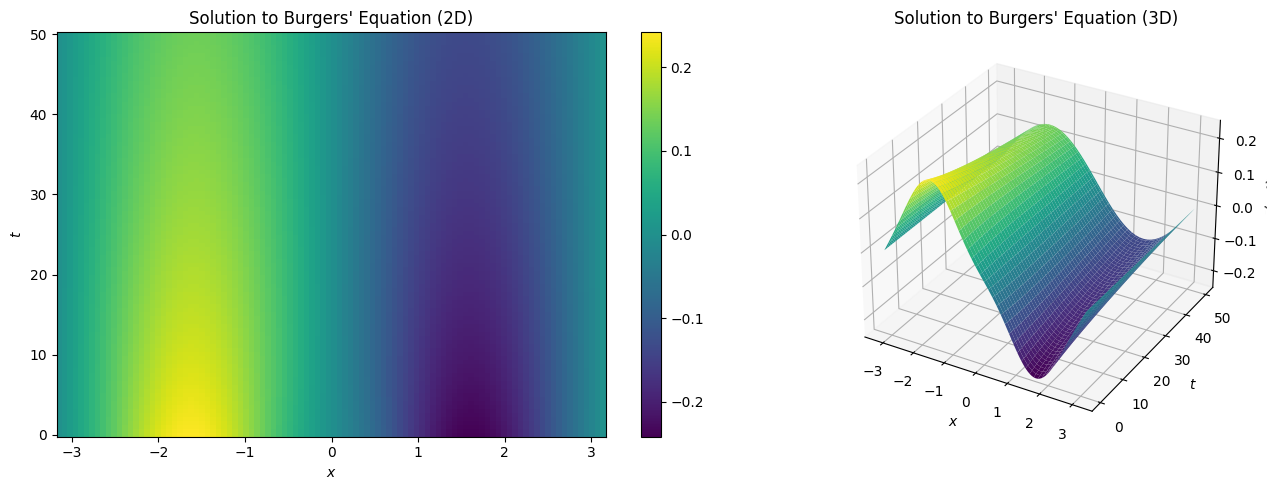

In [ ]:
config.update("jax_enable_x64", True)
# Numerical solution
key = random.PRNGKey(2)
keys = random.split(key, 5)
(x, t, s), (u, u0) = solve_burgers(keys[2], num_sine_terms, sine_amplitude, Nx , Nt, T_lim, period, kappa)

XX, TT = np.meshgrid(x,t)

# Create a new figure with two subplots side by side, with the first being a 3D plot
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(122, projection='3d')
plot_3d(ax1, XX, TT, s.T)
ax1.set_title('Solution to Burgers\' Equation (3D)')

ax2 = fig.add_subplot(121)
plot(ax2, XX, TT, s.T)
ax2.set_title('Solution to Burgers\' Equation (2D)')

plt.tight_layout()
plt.show()

## **Generate DeepONet Data**

In [ ]:
# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P):
    # Numerical solution
    (x, t, s), (u, u0) = solve_burgers(key, num_sine_terms, sine_amplitude, Nx , Nt, T_lim, period, kappa)

    # u is 1 x m

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Sampled input data
    u_train = np.tile(u, (P,1)) # add dimensions-> copy u P times


    # Sample general evaluation points for DeepONet
    x_2_idx = random.choice(subkeys[0], np.arange(Nx), shape = (P,1))
    x_2 = x[x_2_idx]

    t_2_idx = random.choice(subkeys[1], np.arange(Nt), shape = (P,1))
    t_2 = t[t_2_idx]

    y_train_don = np.hstack((x_2, t_2))


    s_train_don = s[x_2_idx, t_2_idx]

    return u_train, y_train_don, s_train_don

In [ ]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, s), (u, u0) = solve_burgers(key, num_sine_terms, sine_amplitude, Nx , Nt, T_lim, period, kappa)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = s.T.flatten()

    return u_test, y_test, s_test

In [ ]:
# Select N_train keys to create N_train Functions
key = random.PRNGKey(0)
keys = random.split(key, N_train)

config.update("jax_enable_x64", True)
u_train, y_train_don, s_train_don = vmap(generate_one_training_data, (0, None))(keys, P_train)

# DeepONet Data
u_don_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_don_train = np.float32(y_train_don.reshape(N_train * P_train,-1))
s_don_train = np.float32(s_train_don.reshape(N_train * P_train,-1))

In [ ]:
key = random.PRNGKey(12345)# different key than training data
keys = random.split(key, N_test)
config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

config.update("jax_enable_x64", False)

In [ ]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, labels,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input
        self.y = y # location
        self.labels = labels # labeled data evaluated at y

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        y = self.y[idx,:]
        labels = self.labels[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = labels
        return inputs, outputs

# **Defining DeepONet Functions**

In [ ]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
        #   b = np.zeros(d_out)
          return W #, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
    #   for W, b in params[:-1]:
      for W in params[:-1]:
          outputs = np.dot(inputs, W)
          inputs = activation(outputs)
    #   W, b = params[-1]
      W = params[-1]
      outputs = np.dot(inputs, W) # + b
      return outputs
  return init, apply

In [ ]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):

        # Network initialization and evaluation functions (tanh)
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        # STEP LENGTH for OPTIMIZER SET HERE --------------------------------
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                                                                      decay_steps=500,
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_don_log = []
        self.loss_test_log = []
        self.loss_AF_test_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs

    # Define DeepONet loss
    def loss_don(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss

    # Define Test loss
    def loss_test(self, params, u_test, y_test, s_test):
      s_pred = self.predict_s(params, u_test, y_test)
      return np.mean((s_test - s_pred)**2)

    # Define Average Fractional Test loss
    def AF_loss_test(self, params, u_test, y_test, s_test):
      s_pred = self.predict_s(params, u_test, y_test)
      return np.mean((s_test - s_pred)**2) / np.mean((s_test)**2)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, don_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_don)(params, don_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, don_dataset, nIter):
        # Define data iterators
        don_data = iter(don_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            don_batch = next(don_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, don_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_don_value = self.loss_don(params, don_batch)
                loss_test_value = self.loss_test(params, u_test, y_test, s_test)
                AFTL_value = self.AF_loss_test(params, u_test, y_test, s_test)

                # Store losses
                self.loss_don_log.append(loss_don_value)
                self.loss_test_log.append(loss_test_value)
                self.loss_AF_test_log.append(AFTL_value)

                # Print losses
                pbar.set_postfix({'Training Loss': loss_don_value,
                                  'Test Loss': loss_test_value, 'AFTL': AFTL_value})

    # Evaluates model predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    # @partial(jit, static_argnums=(0,))
    # def predict_res(self, params, U_star, Y_star):
    #     r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
    #     return r_pred

# **Training the DeepONet**

In [ ]:
batch_size = 512
don_dataset = DataGenerator(u_don_train, y_don_train, s_don_train, batch_size)

The formula being computed for "bound" below is the Rademacher generalization error bound that was proven by Pulkit and Anirbit - although their proof as of now only applies to DeepONets having absolute value activations. So this is kind of testing that theory outside the current ambit of their proof.

In [ ]:


# Train
width = 100
branch_layers = [m, width, width, width]
trunk_layers =  [2, width, width, width]

model = DeepONet(branch_layers, trunk_layers)
model.train(don_dataset, nIter=10000)

gen_error = np.abs(model.loss_don_log[-1] - model.loss_test_log[-1])

# C value computation
branch_params, trunk_params = model.get_params(model.opt_state)
C_vals = []
n = len(branch_params)

# Weight matrices are transposed for this specific implementation (y = XW)
b_n1 = branch_params[n-2].T.shape[0]
t_n1 = trunk_params[n-2].T.shape[0]
p = branch_params[n-1].T.shape[0]

# Spectral Norm computation
branch_spec_norms = []
trunk_spec_norms = []

for i in range(n):
    branch_spec_norms.append(np.linalg.norm(branch_params[i].T, ord=2).item())
    trunk_spec_norms.append(np.linalg.norm(trunk_params[i].T, ord=2).item())


norm_matrix_n = \
    np.abs(np.sum(np.array([np.outer((branch_params[n-1].T)[j], (trunk_params[n-1].T)[j]) for j in range(p)]), axis=0))
norm_vec_B = np.array([np.linalg.norm(np.array([(branch_params[n-2].T)[k1]])) for k1 in range(b_n1)])
norm_vec_T = np.array([np.linalg.norm(np.array([(trunk_params[n-2].T)[k2]])) for k2 in range(t_n1)])

C_1 = (norm_vec_B.T @ norm_matrix_n @ norm_vec_T).item()
C_vals.append(C_1)

for k in range(2, n):
    b_k = branch_params[n-k-1].T.shape[0]
    t_k = trunk_params[n-k-1].T.shape[0]
    norm_matrix_k = np.array([[np.linalg.norm((branch_params[n-k-1].T)[j1])*np.linalg.norm((trunk_params[n-k-1].T)[j2]) for j2 in range(t_k)] for j1 in range(b_k)])
    C_k = np.linalg.norm(norm_matrix_k, ord=2).item()
    C_vals.append(C_k)

bound = (C_vals[0]*C_vals[1])/np.sqrt(N_train*P_train)

print(f"Layers: {n}, m: {m}, width: {width}, N_train: {N_train}, P_train: {P_train}, batch size: {batch_size}")
print(f"C: {C_vals}")
print(f"Branch spectral norms: {branch_spec_norms}")
print(f"Trunk spectral norms : {trunk_spec_norms}")
print("----------------------------------------------")

100%|██████████| 10000/10000 [00:23<00:00, 419.49it/s, Training Loss=0.0011502618, Test Loss=0.03785208, AFTL=1.9332575]


Layers: 3, m: 100, width: 100, N_train: 400, P_train: 2000, batch size: 512
C: [786.985595703125, 22.985933303833008]
Branch spectral norms: [1.9708311557769775, 1.968755841255188, 1.9952383041381836]
Trunk spectral norms : [2.082688093185425, 2.0293970108032227, 2.0337066650390625]
----------------------------------------------


In [ ]:
bound

Array(20.224785, dtype=float32, weak_type=True)

In [ ]:
gen_error

Array(0.03670182, dtype=float32)

#**Visualizing Results**

Average fractional test loss: $\frac{1}{N_{test}}\sum^{N_{test}}_{i=1}\frac{\sum_{j=1}^{P_{test}}(Pred(u_i)(x_j,t_j) - True(u_i)(x_j,t_j))^2}{\sum_{j=1}^{P_{test}} (True(u_i)(x_j,t_j))^2}$

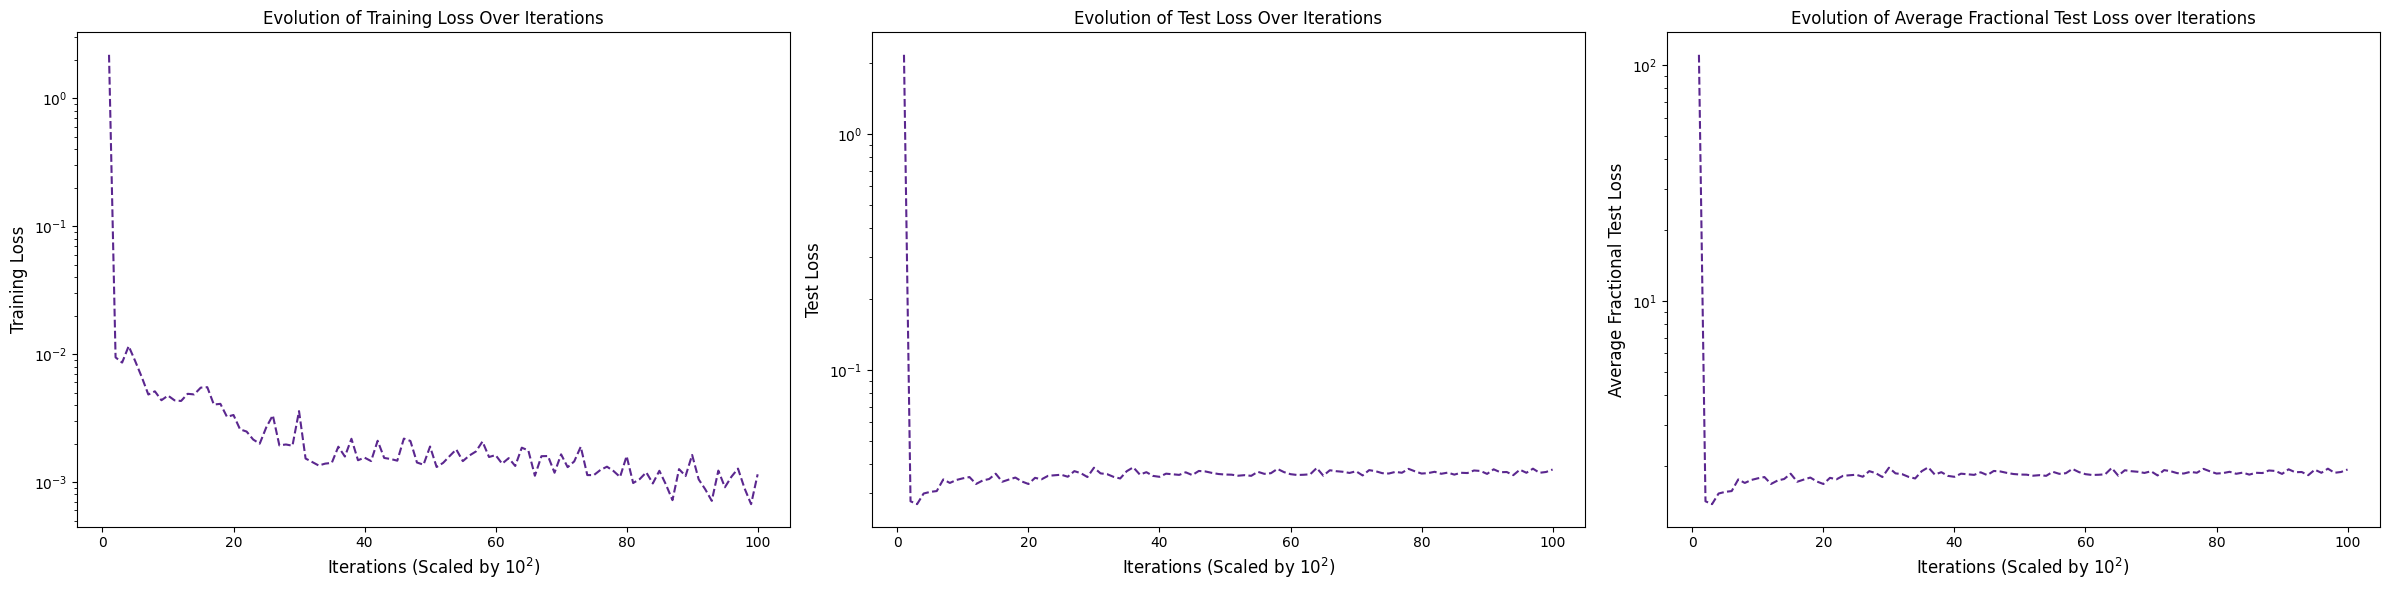

In [ ]:
# Visualizations
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Colors from the 'viridis' colormap
medium_purple = '#5B278F'
light_purple = '#3b528b'
viri_green = '#00A896'

# Total loss per 100 iteration
total_loss_eval_numbers = range(1, len(model.loss_don_log) + 1)
axs[0].plot(total_loss_eval_numbers, model.loss_don_log, '--', color=medium_purple, label='Training loss')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[0].set_ylabel('Training Loss', fontsize='large')
axs[0].set_title('Evolution of Training Loss Over Iterations', fontsize='large')


# Test loss
test_loss_eval_numbers = range(1, len(model.loss_test_log) + 1)
axs[1].plot(test_loss_eval_numbers, model.loss_test_log, '--', color=medium_purple, label='Test loss')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[1].set_ylabel('Test Loss', fontsize='large')
axs[1].set_title('Evolution of Test Loss Over Iterations', fontsize='large')

# Average fractional test loss
AFTL_eval_numbers = range(1, len(model.loss_AF_test_log) + 1)
axs[2].plot(AFTL_eval_numbers, model.loss_AF_test_log, '--', color=medium_purple, label='Average Fractional Test loss')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[2].set_ylabel('Average Fractional Test Loss', fontsize='large')
axs[2].set_title('Evolution of Average Fractional Test Loss over Iterations', fontsize='large')


plt.tight_layout()
plt.show()

# **Evaluate Model**

###  **Visualise Predicted Solution of a New Test Function**

In [ ]:
N_test = 1
P_test = 1000
Nx = 1000
Nt = 1000

key = random.PRNGKey(334) # new key
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = np.linspace(-period*np.pi, period*np.pi, Nx)
t = np.linspace(0, T_lim, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

In [ ]:
print('Test Error for the unseen function: ', np.mean((s_test - s_pred)**2))

Test Error for the unseen function:  0.027895315


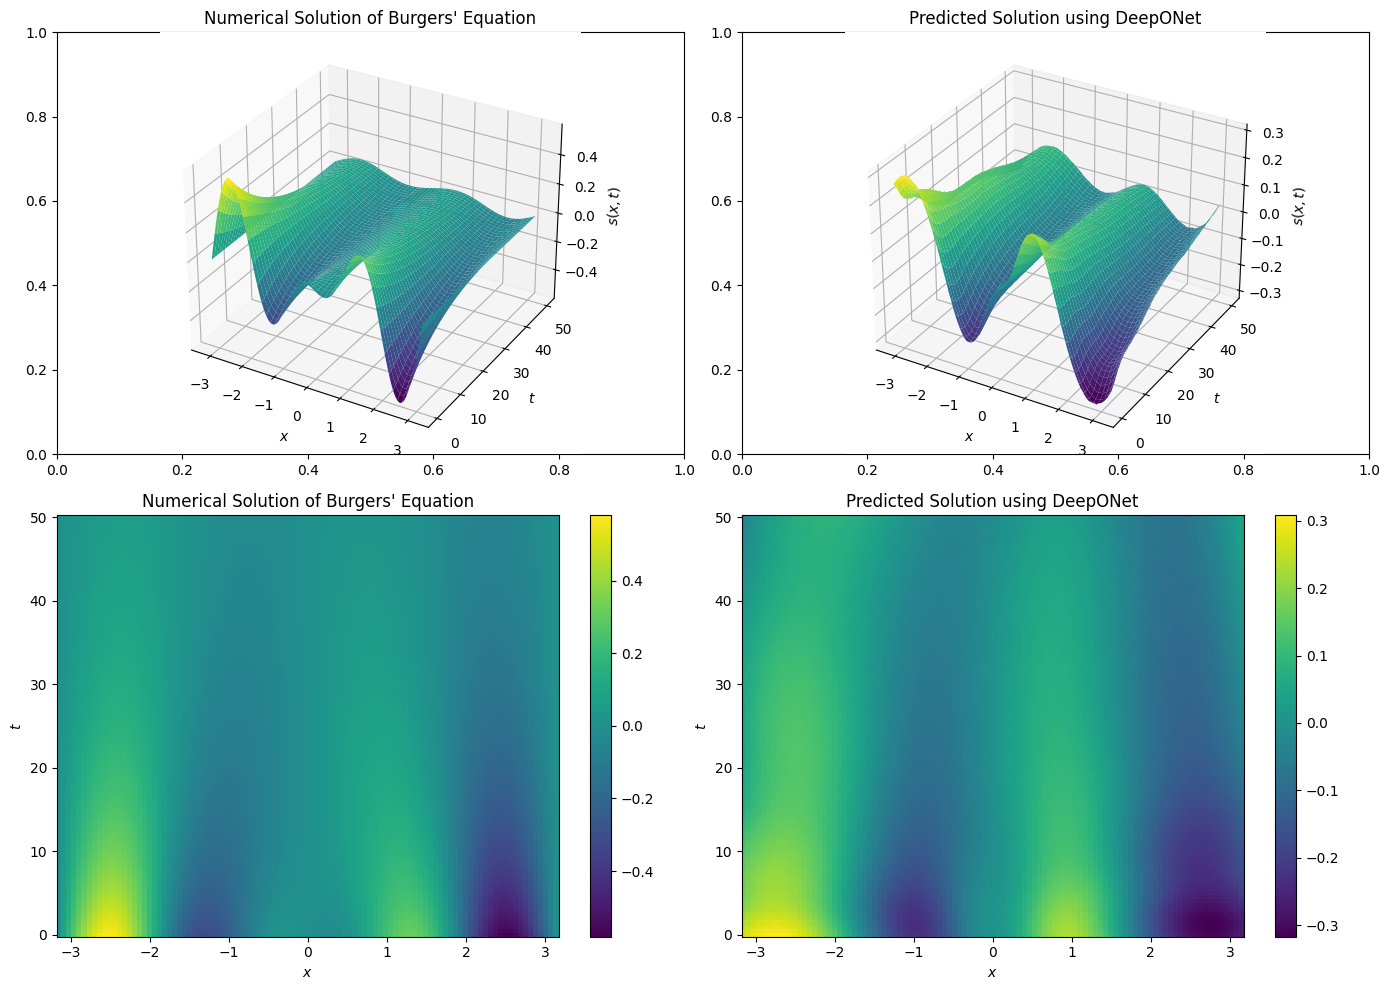

In [ ]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top row: 3D plots
# Numerical Solution of Burgers' Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, TT, S_test)
axs[0, 0].set_title("Numerical Solution of Burgers' Equation", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, TT, S_pred)
axs[0, 1].set_title("Predicted Solution using DeepONet", fontsize='large')

# Bottom row: 2D color plots
# Numerical Solution of Burgers' Equation
plot(axs[1, 0], XX, TT, S_test)
axs[1, 0].set_title("Numerical Solution of Burgers' Equation", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, TT, S_pred)
axs[1, 1].set_title("Predicted Solution using DeepONet", fontsize='large')

plt.tight_layout()
plt.show()

